In [1]:
from fishsense_api_sdk.client import Client
from tqdm.notebook import tqdm
import numpy as np
from tqdm.asyncio import tqdm_asyncio
from fishsense_api_sdk.models.dive_slate_label import DiveSlateLabel
from typing import List
import cv2
import matplotlib.pyplot as plt
from fishsense_api_sdk.models.laser_extrinsics import LaserExtrinsics
from datetime import datetime, timezone
from fishsense_data_processing_workflow_worker.config import settings

In [2]:
INCH_TO_M = 0.0254

In [9]:
async with Client(settings.fishsense_api.url, settings.fishsense_api.username, settings.fishsense_api.password) as client:
    dives = await client.dives.get()
    dives = [dive for dive in dives if dive.priority == "HIGH"]

len(dives), dives[0]

(8,
 Dive(id=383, name='062624_FiveSeas_FSL03', path='2025-02-10 REEF Data Dump SMILE 6/CubaTrip2024_FSL03/062624_FiveSeas_FSL03', dive_datetime=datetime.datetime(2024, 6, 26, 7, 52, 45, tzinfo=TzInfo(0)), priority=<Priority.HIGH: 'HIGH'>, flip_dive_slate=None, camera_id=3, dive_slate_id=10))

In [10]:
async with Client(settings.fishsense_api.url, settings.fishsense_api.username, settings.fishsense_api.password) as client:
    laser_extrinsics_list = await tqdm_asyncio.gather(*[client.dives.get_laser_extrinsics(dive.id) for dive in dives])

    len(laser_extrinsics_list), laser_extrinsics_list[0]

100%|██████████| 8/8 [00:00<00:00, 30.10it/s]


In [11]:
dives_without_calibration = [dive for dive, laser_extrinsics in zip(dives, laser_extrinsics_list) if not laser_extrinsics]

len(dives_without_calibration), dives_without_calibration[0]

(1,
 Dive(id=383, name='062624_FiveSeas_FSL03', path='2025-02-10 REEF Data Dump SMILE 6/CubaTrip2024_FSL03/062624_FiveSeas_FSL03', dive_datetime=datetime.datetime(2024, 6, 26, 7, 52, 45, tzinfo=TzInfo(0)), priority=<Priority.HIGH: 'HIGH'>, flip_dive_slate=None, camera_id=3, dive_slate_id=10))

In [12]:
dive_slate_labels_by_dive_id = {}

async with Client(settings.fishsense_api.url, settings.fishsense_api.username, settings.fishsense_api.password) as client:
    for dive in tqdm(dives_without_calibration):
        dive_slate_labels = await client.labels.get_dive_slate_labels(dive.id)

        dive_slate_labels_by_dive_id[dive.id] = dive_slate_labels

len(dive_slate_labels_by_dive_id)

  0%|          | 0/1 [00:00<?, ?it/s]

1

In [13]:
async with Client(settings.fishsense_api.url, settings.fishsense_api.username, settings.fishsense_api.password) as fs:
    dive_slates = await fs.dive_slates.get()

len(dive_slates), dive_slates[0]

(11,
 DiveSlate(id=5, name='Tic-Tac-Toe 4', dpi=300, path='Dive Slate#4.pdf', created_at=datetime.datetime(2025, 9, 6, 3, 53, 10, 190057, tzinfo=TzInfo(0)), reference_points=[(591.9493127134886, 419.73291956851295), (1180.375218367864, 415.508647477124), (2008.7060450606716, 408.7832988960453), (2598.7223535242415, 401.20588324117523), (594.2177470825221, 1320.1595244257721), (1183.4343179108548, 1318.369903930235), (2016.1826073962275, 1316.5857288918276), (2604.907191981395, 1314.7051789793095)]))

In [14]:
dive_slates_by_id = {dive_slate.id: dive_slate for dive_slate in dive_slates}

dive_slates_by_id

{5: DiveSlate(id=5, name='Tic-Tac-Toe 4', dpi=300, path='Dive Slate#4.pdf', created_at=datetime.datetime(2025, 9, 6, 3, 53, 10, 190057, tzinfo=TzInfo(0)), reference_points=[(591.9493127134886, 419.73291956851295), (1180.375218367864, 415.508647477124), (2008.7060450606716, 408.7832988960453), (2598.7223535242415, 401.20588324117523), (594.2177470825221, 1320.1595244257721), (1183.4343179108548, 1318.369903930235), (2016.1826073962275, 1316.5857288918276), (2604.907191981395, 1314.7051789793095)]),
 6: DiveSlate(id=6, name='Tic-Tac-Toe 5', dpi=300, path='Dive Slate #5.pdf', created_at=datetime.datetime(2025, 9, 6, 3, 53, 10, 190162, tzinfo=TzInfo(0)), reference_points=[(403.8205816493262, 631.5968154288058), (993.2497902769651, 632.7766211186832), (1740.9198685182203, 635.3794945908605), (2328.4124741771443, 635.521328189681), (425.52889197228865, 1488.5791173820157), (1014.7334760788126, 1491.8682245487987), (1758.603030468457, 1496.092149318488), (2346.7834576540045, 1498.101145176125

In [15]:
dive_slates_by_dive_id = {dive.id: dive_slates_by_id[dive.dive_slate_id] for dive in dives if dive.dive_slate_id is not None}

dive_slates_by_dive_id

{383: DiveSlate(id=10, name='V-Slate 3', dpi=300, path='SMILE vslate 3.pdf', created_at=datetime.datetime(2025, 9, 6, 3, 53, 10, 190525, tzinfo=TzInfo(0)), reference_points=[(1179.0084868747833, 117.81684380775803), (2752.091097298008, 1538.4702475910544), (3668.6909445893743, 460.7455616290455), (4069.025033904235, 822.238374386121), (2784.5545688670823, 2374.0171777152314), (816.5862342973786, 561.4466136108025)]),
 279: DiveSlate(id=7, name='Tic-Tac-Toe 6', dpi=300, path='Dive Slate#6.pdf', created_at=datetime.datetime(2025, 9, 6, 3, 53, 10, 190259, tzinfo=TzInfo(0)), reference_points=[(495.4112011445373, 392.73624451189136), (1085.311077010467, 389.554881713577), (1759.819487534749, 385.38891892656096), (2348.1289135916677, 379.9113269488712), (548.2033935446091, 1545.108970466092), (1137.1556910423612, 1539.6503159681731), (1772.0744635842048, 1535.2580570522443), (2360.6314833201213, 1529.5025686051904)]),
 341: DiveSlate(id=8, name='V-Slate 1', dpi=300, path='SMILE vslate 1.pdf'

In [16]:
async with Client(settings.fishsense_api.url, settings.fishsense_api.username, settings.fishsense_api.password) as client:
    camera_intrinsics_list = await tqdm_asyncio.gather(*[client.cameras.get_intrinsics(dive.camera_id) for dive in dives])

len(camera_intrinsics_list), camera_intrinsics_list[0]

100%|██████████| 8/8 [00:00<00:00,  8.83it/s]


(8,
 <fishsense_api_sdk.models.camera_intrinsics.CameraIntrinsics at 0x77eb5ca15220>)

In [17]:
camera_intrinsics_by_dive_id = {dive.id: intrinsics for dive, intrinsics in zip(dives, camera_intrinsics_list)}

camera_intrinsics_by_dive_id

{383: <fishsense_api_sdk.models.camera_intrinsics.CameraIntrinsics at 0x77eb5ca15220>,
 279: <fishsense_api_sdk.models.camera_intrinsics.CameraIntrinsics at 0x77eb3ffd6490>,
 341: <fishsense_api_sdk.models.camera_intrinsics.CameraIntrinsics at 0x77eb5cba6690>,
 347: <fishsense_api_sdk.models.camera_intrinsics.CameraIntrinsics at 0x77eb5cba78a0>,
 349: <fishsense_api_sdk.models.camera_intrinsics.CameraIntrinsics at 0x77eb5cb67bf0>,
 465: <fishsense_api_sdk.models.camera_intrinsics.CameraIntrinsics at 0x77eb5ca15f30>,
 466: <fishsense_api_sdk.models.camera_intrinsics.CameraIntrinsics at 0x77eb3ffd6210>,
 471: <fishsense_api_sdk.models.camera_intrinsics.CameraIntrinsics at 0x77eb5cbd6900>}

In [18]:
def image_coordinate_to_projected_point(
    image_point: np.ndarray, inverted_camera_matrix: np.ndarray
) -> np.ndarray:
    assert isinstance(image_point, np.ndarray)
    assert isinstance(inverted_camera_matrix, np.ndarray)

    homogenous_point_image_space = np.zeros(3, dtype=float)
    homogenous_point_image_space[:2] = image_point
    homogenous_point_image_space[2] = 1

    # define laser ray assuming pinhole camera
    return inverted_camera_matrix @ homogenous_point_image_space

In [19]:
def get_normal_vector_from_rotation_matrix(rotation: np.ndarray) -> np.ndarray:
    assert isinstance(rotation, np.ndarray)
    assert rotation.shape == (3, 3)

    # normal vector is the third column of the rotation matrix
    return rotation[:, 2]

In [20]:
def atanasov_calibration_method(ps: np.ndarray):
    """
    Nikolay's method for laser calibration.
    Inputs:
     - ps: the laser points
    Output: the 5-vector of the laser parameters, with the first 3 being the orientation,
            and the final two being the x and y coordinates of the laser origin
    """
    avg_alpha = np.zeros((3,))
    params = np.zeros((5,))
    for i in range(ps.shape[0]):
        for j in range(ps.shape[0]):
            if i != j:
                v = ps[i] - ps[j]
                if v[2] < 0:
                    v = -v
                avg_alpha += v

    avg_alpha /= np.linalg.norm(avg_alpha)
    if avg_alpha[2] < 0:
        avg_alpha = -avg_alpha

    centroid = np.mean(ps, axis=0)
    scale_factor = centroid[2] / avg_alpha[2]
    params[0:3] = avg_alpha
    params[3:5] = centroid[0:2] - scale_factor * avg_alpha[0:2]
    return params

In [21]:
async with Client(settings.fishsense_api.url, settings.fishsense_api.username, settings.fishsense_api.password) as client:
    for dive in tqdm(dives_without_calibration):
        dive_slate = dive_slates_by_dive_id[dive.id]
        dive_slate_labels: List[DiveSlateLabel] = dive_slate_labels_by_dive_id[dive.id]
        camera_intrinsics = camera_intrinsics_by_dive_id[dive.id]

        # if any(slate.upside_down for slate in dive_slate_labels):
        #     continue

        laser_points = []
        for dive_slate_label in dive_slate_labels:
            laser_label = await client.labels.get_laser_label(dive_slate_label.image_id)
            source_points = dive_slate.reference_points.copy()
            
            for idx in dive_slate_label.skipped_points or []:
                source_points.pop(idx)

            source_points = np.array(source_points)
            body_points = np.zeros((len(source_points), 3), dtype=np.float32)
            body_points[:, :2] = (source_points / float(dive_slate.dpi)) * INCH_TO_M
            image_space = np.array(dive_slate_label.reference_points)

            empty_dist_coeffs = np.zeros((5,))
            ret, rotation_vectors, translation = cv2.solvePnP(
                body_points,
                image_space,
                camera_intrinsics.camera_matrix,
                empty_dist_coeffs,
            )

            if not ret:
                print(f"Could not solve PnP for dive {dive.id} slate label {dive_slate_label.id}")
                continue

            rotation, _ = cv2.Rodrigues(rotation_vectors)
            # transformation_matrix = np.eye(4, dtype=np.float32)
            # transformation_matrix[:3, :3] = rotation
            # transformation_matrix[:3, 3] = translation.T
            # camera_space = np.zeros((len(body_points), 4), dtype=np.float32)
            # camera_space[:, :3] = body_points
            # camera_space[:, 3] = 1
            # camera_space = transformation_matrix @ camera_space.T
            # camera_space = camera_space.T
            # camera_space = camera_space[:, :3]

            camera_space = (rotation @ body_points.T + translation).T

            normal_vector = get_normal_vector_from_rotation_matrix(rotation)
            # normal_vector = np.cross(camera_space[0, :], camera_space[5, :])

            laser_image_point = np.array([laser_label.x, laser_label.y])
            ray = (
                image_coordinate_to_projected_point(
                    laser_image_point, np.linalg.inv(camera_intrinsics.camera_matrix)
                )
                * -1
            )

            if np.any(np.isnan(ray)):
                print(f"NaN ray for dive {dive.id} slate label {dive_slate_label.id}")
                continue

            # print(ray)

            scale_factor = (normal_vector.T @ camera_space[0, :]) / (normal_vector.T @ ray)
            laser_physical_point = ray * scale_factor

            laser_points.append(laser_physical_point)

        laser_points_array = np.array(laser_points)
        laser_params = atanasov_calibration_method(laser_points_array)

        laser_axis = laser_params[:3]
        laser_position = np.zeros(3, dtype=float)
        laser_position[:2] = laser_params[-2:]

        laser_extrinsics = LaserExtrinsics(laser_position, laser_axis, dive.id, dive.camera_id, created_at=datetime.now(timezone.utc))
        await client.dives.put_laser_extrinsics(dive.id, laser_extrinsics)

# normal_vector
# dive_slate_label.id, rotation, translation
# laser_params

  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
import math
from pathlib import Path
from skimage.exposure import adjust_gamma, equalize_adapthist
from skimage.util import img_as_float, img_as_ubyte
import rawpy
import matplotlib.pyplot as plt

In [23]:
def process_raw(image_path: Path):
    with image_path.open("rb") as f:
        with rawpy.imread(f) as raw:
            img = img_as_float(
                raw.postprocess(
                    gamma=(1, 1),
                    no_auto_bright=True,
                    use_camera_wb=True,
                    output_bps=16,
                    user_flip=0,
                )
            )

            hsv = cv2.cvtColor(img_as_ubyte(img), cv2.COLOR_BGR2HSV)
            _, _, val = cv2.split(hsv)

            mid = 20
            mean = np.mean(val)
            meanLog = math.log(mean)
            midLog = math.log(mid * 255)
            gamma = midLog / meanLog
            gamma = 1 / gamma

            img = adjust_gamma(img, gamma=gamma)

            img = equalize_adapthist(img)

            return img_as_ubyte(img[:, :, ::-1])

In [24]:
def rectify(img: np.ndarray, camera_matrix: np.ndarray, distortion_coefficients: np.ndarray) -> np.ndarray:
    return cv2.undistort(
        img,
        camera_matrix,
        distortion_coefficients,
    )

In [26]:
DATA_FOLDER = (Path("../data") / "REEF" / "data").absolute()

224785
[[2311.3102945  1424.40863959]
 [1953.73688754 1123.93623527]
 [1766.22240556 1370.41529841]
 [1674.73816522 1294.85630901]
 [1937.52387213  934.45937016]
 [2388.67665453 1324.03742499]]
[2.03807416e+03 1.31671100e+03 1.00000000e+00]


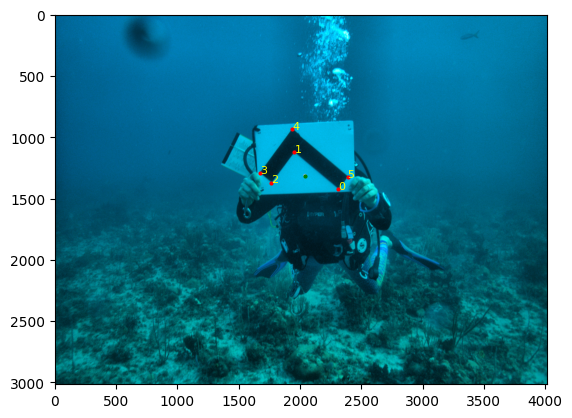

In [27]:
async with Client(settings.fishsense_api.url, settings.fishsense_api.username, settings.fishsense_api.password) as client:
    dive_slate_label
    print(dive_slate_label.label_studio_task_id)
    image = await client.images.get(image_id=dive_slate_label.image_id)
    camera_intrinsics = camera_intrinsics_by_dive_id[dive.id]

    img = process_raw((DATA_FOLDER / image.path).absolute())
    img = rectify(img, camera_intrinsics.camera_matrix, camera_intrinsics.distortion_coefficients)

image_points = camera_space
n, _ = image_points.shape
for idx in range(n):
    image_points[idx, :] /= image_points[idx, 2]

image_points = camera_intrinsics.camera_matrix @ image_points.T
image_points = image_points.T
image_points = image_points[:, :2]
print(image_points)

plt.plot(image_points[:, 0], image_points[:, 1], "ro", markersize=2)
for i, (x, y) in enumerate(image_points):
    plt.text(x, y, str(i), color="yellow", fontsize=8)

image_laser_point = laser_physical_point.copy()
image_laser_point /= image_laser_point[2]
image_laser_point = camera_intrinsics.camera_matrix @ image_laser_point.T
print(image_laser_point)
plt.plot(image_laser_point[0], image_laser_point[1], "go", markersize=2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))